In [ ]:
%matplotlib inline
import os, sys
sys.path.append(os.getcwd())

import time

import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch import nn
from torch import autograd
from torch import optim
import argparse
import csv

from torch.utils.data import TensorDataset, DataLoader, SequentialSampler, Dataset
from torch.utils.data.sampler import RandomSampler, SubsetRandomSampler
from torch.optim import AdamW, Adam

from torch.autograd import Variable
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# get_linear_schedule_with_warmup
import time
import os
import re

# Dataset Mnist

In [ ]:
class MNIST_Dataset(Dataset):

    def __init__(self, dataset, *args, **kwargs):

        super(MNIST_Dataset, self, *args, **kwargs).__init__()
        self.dataset=dataset
        self.use_label_mask=np.zeros(len(dataset), dtype=bool)

    def __getitem__(self, idx):
        tmp=self.dataset[idx]
        return [*tmp, self.use_label_mask[idx],idx]

    def __len__(self):
        return len(self.dataset)

# Sélection aléatoire des 100 échantillons du Mnist

In [ ]:
def Select_Random_Samples(dataset, nb_label, nb_class, train_indices):

    idx_label=[]
    nb_label_each_class=nb_label//nb_class


    for i in range(nb_class):
        print(f"Choosing Random index for the class {i}")
        tmp=iter(dataset)
        idx_class=[datapoint[3] for datapoint in tmp if datapoint[1]==i and datapoint[3] in train_indices]
        idx_label.extend(np.random.choice(idx_class, nb_label_each_class, replace=False))

    return idx_label

# Entrainement du CATGAN

In [ ]:
def train_loop_fun1(data_loader, discriminator, generator, optimizer_G, optimizer_D, latent_size, batch_size, device, λ=5, idx_label=None):
    discriminator.train()
    generator.train()
    t0 = time.time()

    losses_G = []
    losses_D = []

    conditional_entropies_real=[]
    marginal_entropies_real=[]
    cross_entropies=[]
    conditional_entropies_fake=[]
    marginal_entropies_fake=[]

    for batch_idx, (data, targets, use_label, data_idx) in enumerate(data_loader):


#         * Updating the Discriminator *


        # freeze the generator and update the Discriminator
        for p in discriminator.parameters():
            p.requires_grad = True
        for p in generator.parameters():
            p.requires_grad = False

        discriminator.zero_grad()


#         train with real data

        # unsupervised
        y_real = discriminator(data)
        # calcul of the entropy
        # we minimize the entropy so the Discriminator minimize uncertainty
        conditional_entropy_real = conditional_entropy(y_real, batch_size)

        # maximize marginalized entropy over real samples to ensure equal repartition of classes along the data
        marginal_entropy_real = marginal_entropy(y_real)


        # supervised
        #choose just data labeled
        cross_entropy=torch.tensor(0)
        idx_label=torch.where(use_label)[0]
        if len(idx_label)>0:
            #minimize cross entropy
            cross_entropy=cross_entropy_fun(targets[idx_label], y_real[idx_label])


#         train with fake data

        #uniform distribution sampling
        z = torch.randn(batch_size, latent_size, 1, 1).to(device=device)
        fake_images = generator(z)

        y_fake = discriminator(fake_images)
        conditional_entropy_fake = conditional_entropy(y_fake, batch_size)#maximize uncertainty
        # calculate the loss function for the descriminator
        loss_D = conditional_entropy_real - marginal_entropy_real - conditional_entropy_fake + (λ*cross_entropy)
        loss_D.backward()
        optimizer_D.step()

#         * Updating the Generator *

        # error when reusing conditional_entropy_fake
        # freeze the generator and update the Discriminator
        for p in discriminator.parameters():
            p.requires_grad = False
        for p in generator.parameters():
            p.requires_grad = True

        generator.zero_grad()

        ### Fixing the error with y_fake

        y_fake = discriminator(fake_images).detach()
        y_fake.requires_grad_()
        # minimize conditional entropy for the fake data with generator
        conditional_entropy_fake = conditional_entropy(y_fake, batch_size)
        # maximize marginal entropy for the fake data with generator
        marginal_entropy_fake = marginal_entropy(y_fake) #maximize uncertainty
        # calculate loss function for the generator
        loss_G = conditional_entropy_fake - marginal_entropy_fake

        loss_G.backward()

        optimizer_G.step()

        losses_G.append(loss_G.item())
        losses_D.append(loss_D.item())


        #save_entropies
        conditional_entropies_real.append(conditional_entropy_real.item())
        marginal_entropies_real.append(marginal_entropy_real.item())
        cross_entropies.append(cross_entropy.item())
        conditional_entropies_fake.append(conditional_entropy_real.item())
        marginal_entropies_fake.append(marginal_entropy_fake.item())

        retrieve_every=150
        if batch_idx % retrieve_every == 0:
            print(
                f"___ batch index = {batch_idx} / {len(data_loader)} ({100*batch_idx / len(data_loader):.2f}%), time = {time.time()-t0:.2f} secondes ___")
            print(
                f"\tDiscriminator loss = {np.mean(losses_D[-retrieve_every:]):.2f}, H_x[p(y|D)] : {np.mean(marginal_entropies_real[-retrieve_every:]):.2f}, E[H[p(y|x,D)]] : {np.mean(conditional_entropies_real[-retrieve_every:]):.2f}, λE[CE[y,p(y|x,D)]]:{λ*np.mean(conditional_entropies_fake[-retrieve_every:]):.2f}")
            print(
                f"\tGenerator loss = {np.mean(losses_G[-retrieve_every:]):.2f}, H_G[p(y|D)] : {np.mean(marginal_entropies_fake[-retrieve_every:]):.2f}, E[H[p(y|G(z),D)]]: {np.mean(conditional_entropies_fake[-retrieve_every:]):.2f}")
            t0 = time.time()
    return losses_G, losses_D, conditional_entropies_real, marginal_entropies_real, cross_entropies, conditional_entropies_fake, marginal_entropies_fake

#Fonction d'évaluation pour les données de validation et de test

In [ ]:
def eval_loop_fun1(data_loader, discriminator, generator, latent_size, batch_size, device, λ=5, idx_label=None):
    discriminator.eval()
    generator.eval()
    fin_targets = []
    fin_outputs = []

    losses_D = []
    losses_G = []

    conditional_entropies_real=[]
    marginal_entropies_real=[]
    cross_entropies=[]
    conditional_entropies_fake=[]
    marginal_entropies_fake=[]

    for batch_idx, (data, targets, use_label, data_idx) in enumerate(data_loader):


        with torch.no_grad():

#             * loss of the Discriminator *

            # unsupervised

            y_real = discriminator(data)
            # calcul of the entropy
            # we minimize the entropy so the Discriminator minimize uncertainty
            conditional_entropy_real = conditional_entropy(y_real, batch_size)

            # maximize marginalized entropy over real samples to ensure equal repartition of classes along the data
            marginal_entropy_real = marginal_entropy(y_real)


            # supervised
            cross_entropy=torch.tensor(0)
            #recuperate data labeled
            idx_label=torch.where(use_label)[0]
            if len(idx_label)>0:
                #minimize cross entropy
                cross_entropy=cross_entropy_fun(targets[idx_label], y_real[idx_label])


#             train with fake data

            # uniform distribution sampling
            z = torch.randn(batch_size,latent_size, 1, 1).to(device=device)
            fake_images = generator(z)
            y_fake = discriminator(fake_images)

            conditional_entropy_fake = conditional_entropy(y_fake, batch_size)#maximize uncertainty

            # calculate the loss function of the discriminator
            loss_D = conditional_entropy_real - marginal_entropy_real - conditional_entropy_fake + (λ * cross_entropy)


#             * loss of the Generator *
            # maximize marginal entropy for the generator
            marginal_entropy_fake = marginal_entropy(y_fake)#maximize uncertainty
            # calculate the loss function for the generator
            loss_G = conditional_entropy_fake-marginal_entropy_fake

        losses_G.append(loss_G.item())
        losses_D.append(loss_D.item())

        # save entropies
        conditional_entropies_real.append(conditional_entropy_real.item())
        marginal_entropies_real.append(marginal_entropy_real.item())
        cross_entropies.append(cross_entropy.item())
        conditional_entropies_fake.append(conditional_entropy_real.item())
        marginal_entropies_fake.append(marginal_entropy_fake.item())
        # save output
        fin_targets.append(targets.cpu().detach().numpy())
        fin_outputs.append(y_real.cpu().detach().numpy())
    return np.concatenate(fin_outputs), np.concatenate(fin_targets), losses_D, losses_G, conditional_entropies_real, marginal_entropies_real, cross_entropies, conditional_entropies_fake, marginal_entropies_fake


In [ ]:
def evaluate(target, predicted):
    true_label_mask = [1 if (np.argmax(x)-target[i]) ==
                       0 else 0 for i, x in enumerate(predicted)]
    nb_prediction = len(true_label_mask)
    true_prediction = sum(true_label_mask)
    false_prediction = nb_prediction-true_prediction
    accuracy = true_prediction/nb_prediction
    return{
        "accuracy": accuracy,
        "nb exemple": len(target),
        "true_prediction": true_prediction,
        "false_prediction": false_prediction,
    }

#Modèle Générateur

In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, dim=64, nb_channel=1):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
                # input is Z, going into a convolution
                nn.ConvTranspose2d( noise_dim, dim * 4, 4, 1, 0, bias=False),
                nn.BatchNorm2d(dim * 4),
                nn.LeakyReLU(0.1, ),
                # state size. (dim*8) x 4 x 4
                nn.ConvTranspose2d(dim * 4, dim * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(dim * 2),
                nn.LeakyReLU(0.1),
                # state size. (dim*4) x 8 x 8
                nn.ConvTranspose2d(dim * 2, dim, 4, 2, 1, bias=False),
                nn.BatchNorm2d(dim),
                nn.LeakyReLU(0.1),
                # state size. (dim*2) x 16 x 16
                nn.ConvTranspose2d(dim, nb_channel, 4, 2, 3, bias=False),
                nn.Tanh()
                # state size. (nc) x 32 x 32
            )

    def forward(self, input):
        output = self.main(input)
        return output

# Modèle Discriminateur

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, dim=64, nb_channel=1):
        super(Discriminator, self).__init__()
        main = nn.Sequential(
            nn.Conv2d(nb_channel, dim, 4, 2, 3, bias=False),
            nn.BatchNorm2d(dim),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),#64x16x16
            nn.Conv2d(dim, 2 * dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(2*dim),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),#128x8x8
            nn.Conv2d(2 * dim, 4 * dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(4*dim),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),#256x4x4
            nn.Conv2d(4*dim, 4*dim, 4),
            nn.BatchNorm2d(4*dim),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),#256x1x1
            nn.Conv2d(4*dim, 10, 1)
        )

        self.main = main
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input):
        output = self.main(input)
        output = output.view(-1, 10)
        output = self.softmax(output)
        return output

# Les entropies de Shanon H

In [ ]:
# marginalized entropy
def marginal_entropy(y):
    y1 = y.mean(0)
    y2 = -torch.sum(y1*torch.log(y1+ 1e-7))
    return y2

# conditional entropy
def conditional_entropy(y, batch_size):
    y1 = -y*torch.log(y + 1e-7)
    y2 = 1.0/batch_size*y1.sum()
    return y2

# cross entropy
def cross_entropy_fun(targets, predicted):
    loss = nn.CrossEntropyLoss()
    return loss(predicted, targets)

In [ ]:
torch.autograd.set_detect_anomaly(True)

# CatGAN with λ=5

In [ ]:
! mkdir catgan
! mkdir catgan/discriminator
! mkdir catgan/generator

In [ ]:
TRAIN_BATCH_SIZE=100
EPOCH=1
validation_split = .5
random_seed= 42
device="cpu"
lr=3e-5#1e-3
nb_training_label=100
nb_class=10
latent_size=100
λ=5
learning_rate = 1e-3

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

print('Loading MNIST Dataset...')

dataset = MNIST('./data', transform=img_transform,train=True ,download=True)
dataset_test = MNIST('./data', transform=img_transform,train=False ,download=True)
mnist_dataset=MNIST_Dataset(dataset)



# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))


dataset_test_size = len(dataset_test)
indices_test = list(range(dataset_test_size))
split = int(np.floor(validation_split * dataset_test_size))

#random les indices des données de validation
np.random.seed(random_seed)
np.random.shuffle(indices_test)
np.random.shuffle(indices)

train_indices, val_indices = indices_test[split:], indices_test[:split]

idx_label=Select_Random_Samples(mnist_dataset, nb_training_label, nb_class, indices)
mnist_dataset.use_label_mask[idx_label]=True

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    mnist_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler)

valid_data_loader=DataLoader(
    mnist_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler)


num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)



Loading MNIST Dataset...
Choosing Random index for the class 0
Choosing Random index for the class 1
Choosing Random index for the class 2
Choosing Random index for the class 3
Choosing Random index for the class 4
Choosing Random index for the class 5
Choosing Random index for the class 6
Choosing Random index for the class 7
Choosing Random index for the class 8
Choosing Random index for the class 9


In [ ]:
discriminator=Discriminator()
generator=Generator()
optimizer_G=AdamW(generator.parameters(), lr=lr)
optimizer_D=AdamW(discriminator.parameters(), lr=lr)





val_losses_G=[]
val_losses_D=[]
batches_losses_D=[]
batches_losses_G=[]
val_acc=[]

conditional_entropies_real=[]
marginal_entropies_real=[]
cross_entropies=[]
conditional_entropies_fake=[]
marginal_entropies_fake=[]

val_conditional_entropies_real=[]
val_marginal_entropies_real=[]
val_cross_entropies=[]
val_conditional_entropies_fake=[]
val_marginal_entropies_fake=[]


for epoch in range(EPOCH):
    t0 = time.time()
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp_G, batches_losses_tmp_D, conditional_entropies_real_tmp, marginal_entropies_real_tmp, cross_entropies_tmp, conditional_entropies_fake_tmp, marginal_entropies_fake_tmp=train_loop_fun1(train_data_loader, discriminator, generator, optimizer_G, optimizer_D, latent_size, TRAIN_BATCH_SIZE, device, λ)
    epoch_loss_D=np.mean(batches_losses_tmp_D)
    epoch_loss_G=np.mean(batches_losses_tmp_G)
    print(f"\n*** avg_Generator_loss : {epoch_loss_G:.2f}, avg_Discriminator_loss : {epoch_loss_D:.2f}, time : ~{(time.time()-t0)//60} min ({time.time()-t0:.2f} sec) ***\n")
    t1=time.time()
    output, target, val_losses_tmp_D, val_losses_tmp_G, val_conditional_entropies_real_tmp, val_marginal_entropies_real_tmp, val_cross_entropies_tmp, val_conditional_entropies_fake_tmp, val_marginal_entropies_fake_tmp=eval_loop_fun1(valid_data_loader, discriminator, generator, latent_size, TRAIN_BATCH_SIZE, device, λ)
    print(f"==> evaluation : avg_Generator_loss = {np.mean(val_losses_tmp_G):.2f}, avg_Discriminator_loss = {np.mean(val_losses_tmp_D):.2f}, time : {time.time()-t1:.2f} sec\n")
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses_D.append(val_losses_tmp_D)
    val_losses_G.append(val_losses_tmp_G)
    batches_losses_D.append(batches_losses_tmp_D)
    batches_losses_G.append(batches_losses_tmp_G)

    conditional_entropies_real.append(conditional_entropies_real_tmp)
    marginal_entropies_real.append(marginal_entropies_real_tmp)
    cross_entropies.append(cross_entropies_tmp)
    conditional_entropies_fake.append(conditional_entropies_fake_tmp)
    marginal_entropies_fake.append(marginal_entropies_fake_tmp)

    val_conditional_entropies_real.append(val_conditional_entropies_real_tmp)
    val_marginal_entropies_real.append(val_marginal_entropies_real_tmp)
    val_cross_entropies.append(val_cross_entropies_tmp)
    val_conditional_entropies_fake.append(val_conditional_entropies_fake_tmp)
    val_marginal_entropies_fake.append(val_marginal_entropies_fake_tmp)

    print(f"\t§§ CatGAN model has been saved §§")
    torch.save(discriminator, f"catgan/discriminator/CatGAN_discriminator_model_epoch{epoch+1}.pt")
    torch.save(generator, f"catgan/generator/CatGAN_generator_model_epoch{epoch+1}.pt")

<Axes: title={'center': 'loss'}>

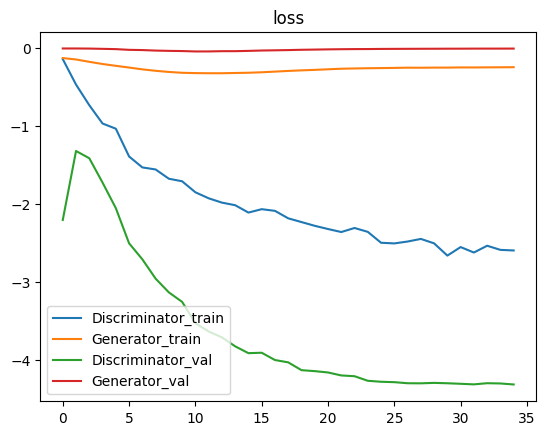

In [ ]:
pd.DataFrame(np.array([[np.mean(x) for x in batches_losses_D], [np.mean(x) for x in batches_losses_G], [np.mean(x) for x in val_losses_D], [np.mean(x) for x in val_losses_G]]).T,
                   columns=['Discriminator_train', 'Generator_train', 'Discriminator_val', 'Generator_val']).plot(title="loss")

<Axes: title={'center': 'loss'}>

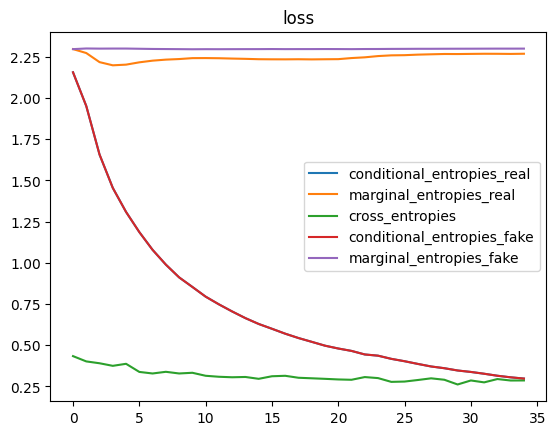

In [ ]:
pd.DataFrame(np.array([[np.mean(x) for x in conditional_entropies_real], [np.mean(x) for x in marginal_entropies_real], [np.mean(x) for x in cross_entropies], [np.mean(x) for x in conditional_entropies_fake], [np.mean(x) for x in marginal_entropies_fake]]).T,
                   columns=['conditional_entropies_real', 'marginal_entropies_real', 'cross_entropies', 'conditional_entropies_fake', 'marginal_entropies_fake']).plot(title="loss")

<Axes: title={'center': 'accuracy'}>

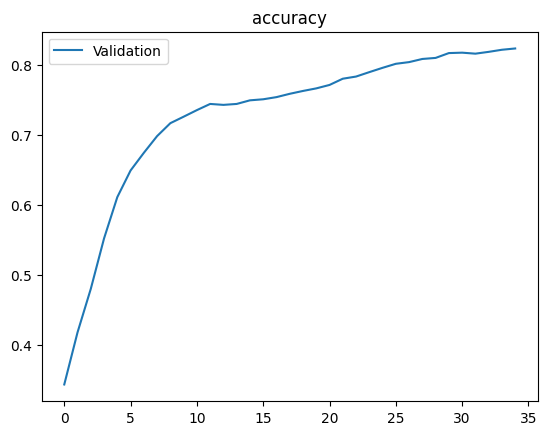

In [ ]:
pd.DataFrame(np.array(val_acc).T,
                   columns=['Validation']).plot(title="accuracy")

In [ ]:
print(f"maximal Accuracy of {round(max(val_acc),2)} on the epoch {np.argmax(val_acc)+1}")

maximal Accuracy of 0.82 on the epoch 35


In [ ]:
# test on MNIST

generator_model_test=torch.load("./catgan/generator/CatGAN_generator_model_epoch11.pt")
discriminator_model_test=torch.load("./catgan/discriminator/CatGAN_discriminator_model_epoch11.pt")
test_losses=[]
test_acc=[]
t1=time.time()
test_dataset = MNIST('./data', transform=img_transform,train=False)# download=True)
test_mnist_dataset=MNIST_Dataset(test_dataset)
test_data_loader=DataLoader(
    test_mnist_dataset,
    batch_size=TRAIN_BATCH_SIZE)
output, target, test_losses_D, test_losses_G, test_conditional_entropies_real, test_marginal_entropies_real, test_cross_entropies, test_conditional_entropies_fake, test_marginal_entropies_fake=eval_loop_fun1(test_data_loader, discriminator_model_test, generator_model_test, latent_size, TRAIN_BATCH_SIZE, device, λ)
print(f"==> evaluation : avg_discriminator_loss = {np.mean(test_losses_D):.2f}, avg_generator_loss = {np.mean(test_losses_G):.2f}, time : {time.time()-t1:.2f} sec\n")
test_evaluate=evaluate(target.reshape(-1), output)
print(f"=====>\t{test_evaluate}")
# test_acc.append(test_evaluate['accuracy'])
# test_losses.append(test_losses_D, test_losses_G)

==> evaluation : avg_discriminator_loss = -3.53, avg_generator_loss = -0.04, time : 33.88 sec

=====>	{'accuracy': 0.7472, 'nb exemple': 10000, 'true_prediction': 7472, 'false_prediction': 2528}


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_classes = np.argmax(output, axis=1)  # Convert probabilities to class labels

# Calculate confusion matrix
conf_matrix = confusion_matrix(target,y_pred_classes)

# Afficher la matrice de confusion
print(conf_matrix)

[[ 948    0    3    5    1    0    9    1   13    0]
 [   0 1105    3    5    0    0    3    0   18    1]
 [  28    3  853   24   15    0   22   10   74    3]
 [  16    2   33  858    0    0    2   15   72   12]
 [   0    3    8    1  493    0   21    0   24  432]
 [  51   40   18  373   17    8   12   15  324   34]
 [  34   11   13    0    1    0  871    0   26    2]
 [   6   21   42    8    4    0    1  808   45   93]
 [  16    5    9  198    2    0    8    5  707   24]
 [  15    7   20   18   32    0    3   17   76  821]]


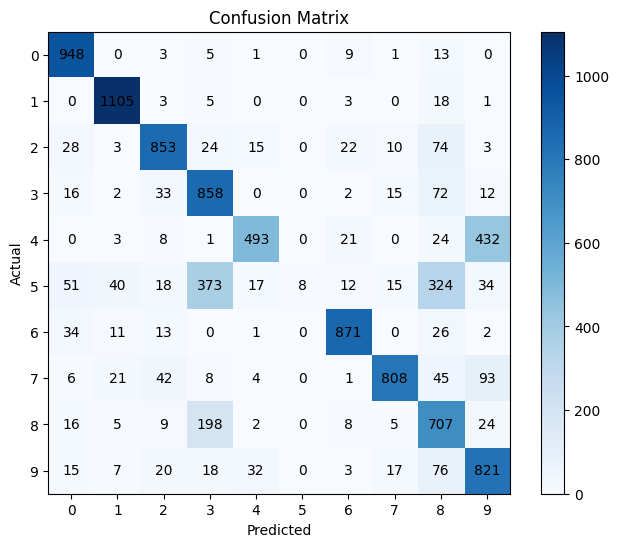

In [ ]:
# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()

# Adding labels
num_classes = conf_matrix.shape[0]
plt.xticks(np.arange(num_classes))
plt.yticks(np.arange(num_classes))
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Displaying the values in the cells
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')

plt.show()